# Identify permitted and potentially unpermitted attached and detached units in San Jose (2020)

In [22]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import math
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# File paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching')
SJ_RES_PARCELS_FP = os.path.join(INPUT_FP, 'inputs', 'san_jose_parcels_res.geojson')
ZONING_FP = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [4]:
# Load data
# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * Building permits
bldg_active = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_active.geojson'))
bldg_recent = gpd.read_file(os.path.join(INPUT_FP, 'inputs','permits', 'bldg_recent.geojson'))
bldg_expired = gpd.read_file(os.path.join(INPUT_FP, 'inputs', 'permits', 'bldg_expired.geojson'))

# * Zoning
sj_zoning = gpd.read_file(ZONING_FP)
sj_residential = sj_zoning[(sj_zoning['ZONING'].str.contains('R-1')) | (sj_zoning['ZONING'].str.contains('R-2')) |\
         ((sj_zoning['ZONING'].str.contains('R-M')) & (sj_zoning['ZONING'] != 'R-MH'))]

# * parcel+permit
sj_parcel_permit = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])
sj_permit_noparcel['geometry'] = gpd.GeoSeries.from_wkt(sj_permit_noparcel['geometry'])

Handle active permits differently than expired permits
- Expired permits barely report dwelling units and square footage
- Should we filter really finely like we do for active permits, or filter for just work description as we do for expired permits to catch ALL the construction permits we can find? I worry that some of the buildings we infer will be under non-SFR permits

Keep this block of code in case we want to filter more specifically for possible dwelling units, but we will work with the more relaxed conditions to get more possible permits to compare to

In [5]:
# Filter permits
cols = list(bldg_active.columns) + ['permit_status']
permits = gpd.GeoDataFrame(columns=cols)
for i, status in zip([bldg_active, bldg_recent, bldg_expired], ['active', 'recent', 'expired']):
    i['permit_status'] = status
    permits = pd.concat([permits, i[i['WORKDESC'].isin(['New Construction', 'Additions/Alterations'])]])
permits = permits.reset_index(drop=True)

permits.crs = "EPSG:4326"

# Functions

In [28]:
def match_parcel(parcel_apn):
    # Obtain parcel-level data
    parcel_inputs = parcel_level_data(
      parcel_apn, sj_parcels_res. sj_parcel_permit)
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_inputs

    # Incorporate OSM data
    parcel_buildings = process_OSM_data(
      inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel)

    # Incorporate permit data
    parcel_buildings = process_permit_data(permits_parcel, parcel_buildings)

    return parcel_buildings

In [29]:
def parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # clip inferred buildings and osm buildings
    # i don't think clip is a good idea since it truncates the inferences according to the mask
    # inferred_buildings_2020_parcel = gpd.clip(building_inference_2020, parcel_bounds)

    # def mask_buildings(df, parcel_bounds):
    #   df_out = df.sjoin(parcel_bounds[['geometry','geom']])
    #   # print(df_out)
    #   df_out['iou'] = df_out['geometry'].intersection(df_out['geom']).area/df_out['geom'].area
    #   df_out = df_out[df_out['iou'] > 0.7]
    #   return df_out

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.7]
        if df_out.empty:
            return None
        else:
            return df_out

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

In [124]:
MIN_ATTACHED_SIZE = 40
MIN_ATTACHED_SIZE_2020_2016_DIFF = 40
MIN_ATTACHED_SIZE_OSM_2016_DIFF = 40

def process_OSM_data(inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel):
    # Returns a gpd.GeoDataFrame with the following columns:
    #   - GEOID, area, small, large
    #   - flags: OSM_flag, expansion_OSM_flag, main_building_flag, expansion_2016_flat
    #   - building geometry
    gpd_cols = ['main_building_flag', 'OSM_flag', 'expansion_OSM_flag', 'expansion_2016_flag', 'geometry']
    parcel_buildings = gpd.GeoDataFrame(geometry=[], columns=gpd_cols)
    
    # Drop OSM index_left column
    if osm_buildings_parcel is not None and 'index_left' in osm_buildings_parcel.columns:
        osm_buildings_parcel.drop('index_left', axis=1, inplace=True)
        
    # Identify main 2016 building to check for expansions in cases below
    inference_main_build_geom_2016 = None
    if inferred_buildings_2016_parcel is not None:
        # Identify 2016 main building
        inferred_buildings_2016_parcel = inferred_buildings_2016_parcel.sort_values(
            'area', ascending=False)
        inference_main_build_2016 = inferred_buildings_2016_parcel.iloc[0]
        inference_main_build_geom_2016 = inference_main_build_2016['geometry']

        
    # Case 1: No inference nor OSM data ----------------- 
    if inferred_buildings_2020_parcel is None and osm_buildings_parcel is None:
        return parcel_buildings

    
    # Case 2: No inference but OSM data ----------------- 
    # We fully rely on OSM data
    if inferred_buildings_2020_parcel is None and osm_buildings_parcel is not None:
        parcel_buildings = osm_buildings_parcel.copy()
        parcel_buildings = parcel_buildings.sort_values('area', ascending=False)
        parcel_buildings['main_building_flag'] = parcel_buildings.apply(
            lambda row: True if row.name == 0 else False, axis=1)
        parcel_buildings['OSM_flag'] = True
        parcel_buildings['expansion_OSM_flag'] = False
        parcel_buildings['expansion_2016_flag'] = None
        
        # Check for OSM expansion vs 2016
        if inference_main_build_geom_2016 is not None: 
            parcel_buildings['expansion_2016_flag'] = False
            
            # Get OSM main building
            osm_main_build = osm_buildings_parcel.sort_values('area', ascending=False).iloc[[0]]
            osm_main_build_geom = osm_main_build['geometry'].iloc[0]
            
            union_main_build = osm_main_build_geom.union(inference_main_build_geom_2016)
            diff_OSM_16 = compute_largest_protruding_poly(
                union_main_build, inference_main_build_geom_2016)
            
            if diff_OSM_16['area'] > MIN_ATTACHED_SIZE_OSM_2016_DIFF:
                parcel_buildings['expansion_2016_flag'] = parcel_buildings.apply(
                lambda row: True if row.name == 0 else False, axis=1)
        return parcel_buildings[gpd_cols]
    
    
    # Case 3: Inference and no OSM data ----------------- 
    if osm_buildings_parcel is None:

        # i. Identify main building in 2020 data as the largest polygon
        inferred_buildings_2020_parcel = inferred_buildings_2020_parcel.sort_values(
            'area', ascending=False)
        inference_main_build = inferred_buildings_2020_parcel.iloc[[0]]
        inference_main_build_geom = inference_main_build['geometry'].iloc[0]
        expansion_2016_flag = None

        parcel_buildings = inference_main_build.copy()

        # ii. Compare to 2016 footprint
        if inference_main_build_geom_2016 is not None:
            expansion_2016_flag = False
            union_main_build = inference_main_build_geom.union(inference_main_build_geom_2016)
            diff_20_16 = compute_largest_protruding_poly(union_main_build, inference_main_build_geom_2016)

            if diff_20_16['area'] > MIN_ATTACHED_SIZE_2020_2016_DIFF:
                parcel_buildings = inference_main_build_2016.copy()
                expansion_2016_flag = True

        parcel_buildings['expansion_2016_flag'] = expansion_2016_flag
        parcel_buildings['expansion_OSM_flag'] = None
        parcel_buildings['main_building_flag'] = True
        parcel_buildings['OSM_flag'] = False
        parcel_buildings = parcel_buildings[gpd_cols]

        # iii. Add inferred small buildings 
        inferred_small = inferred_buildings_2020_parcel.iloc[1:].copy()
        inferred_small['expansion_OSM_flag'] = False
        inferred_small['expansion_2016_flag'] = False
        inferred_small['OSM_flag'] = False
        inferred_small['main_building_flag'] = False
        parcel_buildings = pd.concat([parcel_buildings, inferred_small[gpd_cols]])

        return parcel_buildings[gpd_cols]

    # Case 4: Inference and OSM data -----------------   
    parcel_buildings = gpd.GeoDataFrame(geometry=[])

    # i. Identify main building(s) in OSM and inferences
    osm_main_build = osm_buildings_parcel.sort_values('area', ascending=False).iloc[[0]]
    osm_main_build_geom = osm_main_build['geometry'].iloc[0]

    inference_main_build = inferred_buildings_2020_parcel.sjoin(
        osm_main_build, how='left', predicate='intersects')
    inference_main_build = inference_main_build.loc[~inference_main_build['index_right'].isna()]
    inference_main_build_geom = inference_main_build.geometry.unary_union
    inference_main_build.drop('index_right', axis=1, inplace=True)
    
    expansion_OSM_flag = False
    osm_flag = True
    # If there is no overlap between model inferences and OSM, we use OSM main build
    if len(inference_main_build) == 0:
        inference_main_build_geom = osm_main_build_geom
        
    # * Check for building expansion
    # ** From OSM
    union_main_build = inference_main_build_geom.union(osm_main_build_geom)
    diff_main_build = compute_largest_protruding_poly(union_main_build, osm_main_build_geom)

    parcel_main_build_geom = osm_main_build_geom
    if (diff_main_build['area'] > MIN_ATTACHED_SIZE):
        expansion_OSM_flag = True
        osm_flag = False
        parcel_main_build_geom = union_main_build
        
    # ** From 2016
    expansion_2016_flag = None
    if inference_main_build_geom_2016 is not None:
        expansion_2016_flag = False
        union_main_build = inference_main_build_geom.union(inference_main_build_geom_2016)
        diff_20_16 = compute_largest_protruding_poly(union_main_build, inference_main_build_geom_2016)

        if diff_20_16['area'] > MIN_ATTACHED_SIZE_2020_2016_DIFF:
            expansion_2016_flag = True

    # Generate main building gpd and append to parcel buildlings
    parcel_main_build = gpd.GeoDataFrame(geometry=[parcel_main_build_geom], crs='EPSG:4326')
    parcel_main_build['main_building_flag'] = True
    parcel_main_build['expansion_OSM_flag'] = expansion_OSM_flag
    parcel_main_build['expansion_2016_flag'] = expansion_2016_flag
    parcel_main_build['OSM_flag'] = osm_flag
    parcel_buildings = pd.concat([parcel_buildings, parcel_main_build[gpd_cols]])

    # ii. Match small buildings
    osm_buildings_parcel_small = osm_buildings_parcel.sort_values(
        'area', ascending=False).iloc[1:].copy()
    inferred_buildings_2020_parcel_small = inferred_buildings_2020_parcel.sjoin(
        inference_main_build[['GEOID_left', 'geometry']], how='left', predicate='intersects')
    inferred_buildings_2020_parcel_small = inferred_buildings_2020_parcel_small.loc[
        inferred_buildings_2020_parcel_small['index_right'].isna()]
    inferred_buildings_2020_parcel_small.drop('index_right', axis=1, inplace=True)

    parcel_small_build = match_small_buildings(
        inferred_buildings_2020_parcel_small, osm_buildings_parcel_small, gpd_cols)

    parcel_buildings = pd.concat([parcel_buildings, parcel_small_build[gpd_cols]])
    return parcel_buildings[gpd_cols]


In [31]:
def compute_largest_protruding_poly(union_build, base_build):
    """
    Note we care about concentrated building
    # expansions along a single wall and not general changes in building footprint due to noisy
    # inferences so we isolate the largest protruding polygon
    """
    diff_main_build = gpd.GeoSeries(union_build.difference(base_build), crs='EPSG:4326')
    diff_main_build = diff_main_build.explode(ignore_index=True, index_parts=False)
    
    diff_main_build = gpd.GeoDataFrame(geometry=diff_main_build, crs='EPSG:4326')
    diff_main_build['area'] = diff_main_build.to_crs('EPSG:26910').area
    diff_main_build = diff_main_build.sort_values('area', ascending=False).iloc[0]
    return diff_main_build

In [37]:
def match_small_buildings(inferred, osm, gpd_cols):
    """
    """
    # Note: we want to default to using OSM unless there are small buildings not 
    # captured by OSM

    if len(osm) == 0 and len(inferred) == 0:
        return gpd.GeoDataFrame(geometry=[], columns=gpd_cols)

    if (len(osm) == 0 and len(inferred) > 0) or (len(osm) > 0 and len(inferred) == 0):
        parcel_small_build = osm.copy() if len(osm) > 0 else inferred.copy()
        parcel_small_build['main_building_flag'] = False
        parcel_small_build['OSM_flag'] = True if len(osm) > 0 else False
        parcel_small_build['expansion_OSM_flag'] = False
        parcel_small_build['expansion_2016_flag'] = False
        return parcel_small_build[gpd_cols]

    # Default to OSM
    parcel_small_build = osm.copy()
    parcel_small_build['main_building_flag'] = False
    parcel_small_build['OSM_flag'] = True
    parcel_small_build['expansion_OSM_flag'] = False
    parcel_small_build['expansion_2016_flag'] = False

    # Matching
    inferred_match = inferred.sjoin(osm, predicate='intersects', how='left')

    # Keep only isolated inferences not captured in OSM
    inferred_match = inferred_match.loc[inferred_match['index_right'].isna()]
    inferred_match = inferred_match[[
      'GEOID_left', 'area_left', 'small_left', 'large_left', 'geometry']]
    inferred_match.rename(
      columns={c: c.replace('_left', '') for c in inferred_match.columns}, 
      inplace=True)
    inferred_match['main_building_flag'] = False
    inferred_match['OSM_flag'] = False
    inferred_match['expansion_2016_flag'] = False
    inferred_match['expansion_OSM_flag'] = False

    parcel_small_build = pd.concat([parcel_small_build, inferred_match[gpd_cols]])
    return parcel_small_build[gpd_cols]

In [33]:
def process_permit_data(permits_parcel, parcel_buildings):
    if len(permits_parcel) > 0:
        # TO DO
        pass
    else:
        return parcel_buildings

# Main

In [ ]:
shortlist = gpd.GeoDataFrame()

# Loop over each parcel
parcel_apns = sj_parcels_res['APN'].unique()
for parcel_apn in parcel_apns:
    shortlist_parcel = match_parcel(parcel_apn)

    # Append to shortlist
    if len(shortlist_parcel) > 0:
        shortlist = pd.concat([shortlist, shortlist_parcel])

In [2]:
# 3.5 Sort shortlists
# TO DO
# Risk levels:
# highest risk, no permitted additions of any kind, and you detect detached
# no permitted additions of any kind, and you detect attached
# permitted detached ADU, you detect more than one detached
# permitted detached ADU, you detect attached and detached
# permitted attached ADU, you detect attached and detached
# permitted attached ADU, you detect a detached (or vice versa)
# permitted attached ADU and detached ADU, you detect anything unpermitted

# Test OSM

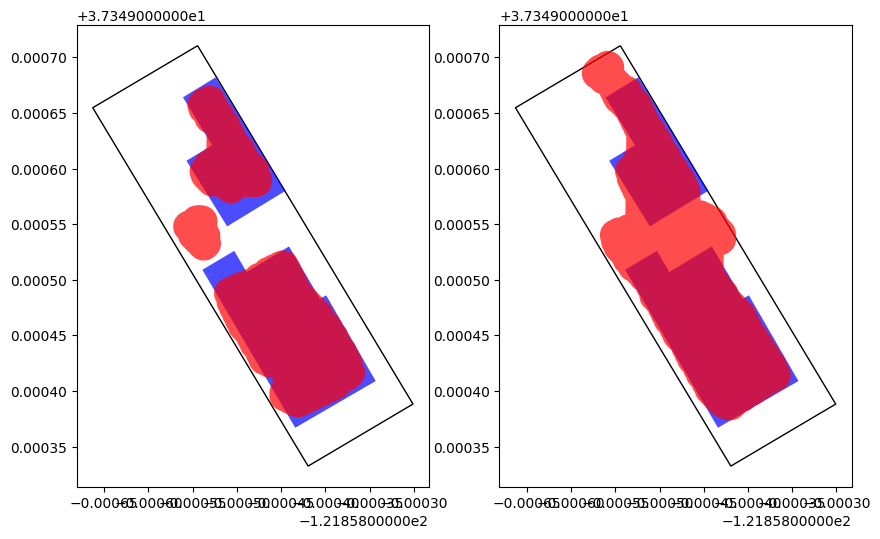

In [34]:
adus=[ '48148034', '48148081', '48148035', '48148045', '48147006', '48147016', 
      '48114077', '48114071', '48114039', '48114041', '48114037'
      ]

parcel_apn='48114037'
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
parcel_bounds.plot(ax=ax1, edgecolor='black', facecolor='none')
osm_buildings_parcel.plot(ax=ax1, color='blue', alpha=0.7)
inferred_buildings_2020_parcel.plot(ax=ax1, color='red', alpha=0.7)

parcel_bounds.plot(ax=ax2, edgecolor='black', facecolor='none')
osm_buildings_parcel.plot(ax=ax2, color='blue', alpha=0.7)
inferred_buildings_2016_parcel.plot(ax=ax2, color='red', alpha=0.7)
plt.show()

In [35]:
adus=[ '48148034', '48148081', '48148035', '48148045', '48147006', '48147016', 
      '48114077', '48114071', '48114039', '48114041', '48114037'
      ]

parcel_apn='48114037'
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

In [38]:
# Incorporate OSM data
parcel_buildings = process_OSM_data(
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel)

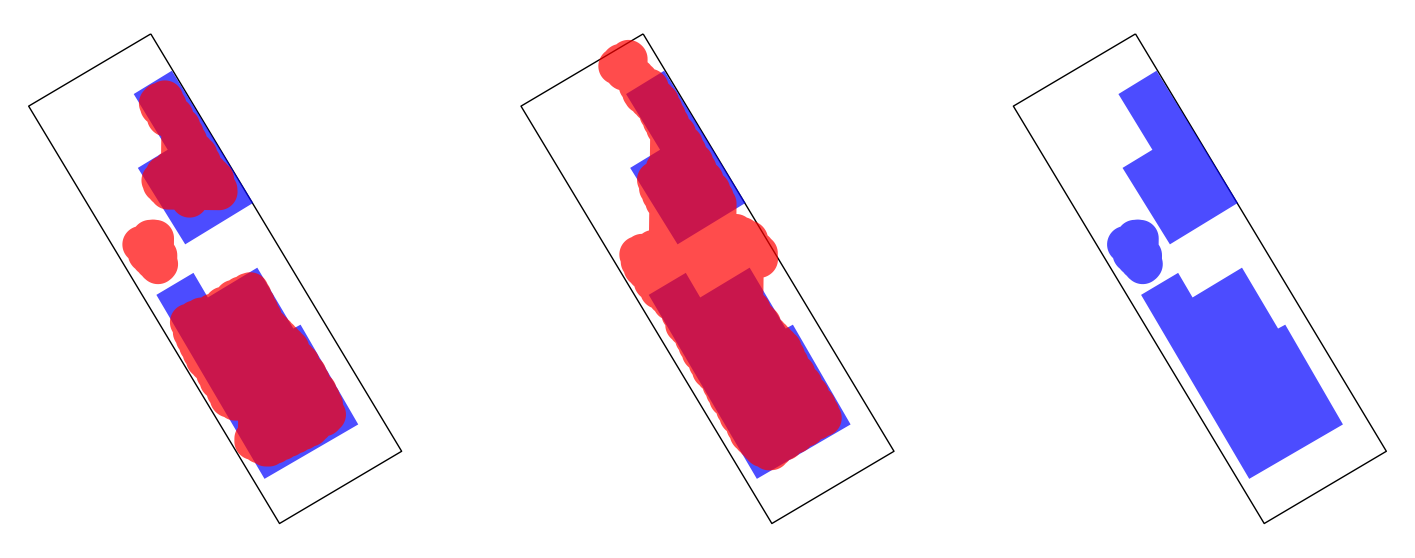

In [39]:
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 8))
parcel_bounds.plot(ax=ax1, edgecolor='black', facecolor='none')
osm_buildings_parcel.plot(ax=ax1, color='blue', alpha=0.7)
inferred_buildings_2020_parcel.plot(ax=ax1, color='red', alpha=0.7)
ax1.axis('off')

parcel_bounds.plot(ax=ax2, edgecolor='black', facecolor='none')
osm_buildings_parcel.plot(ax=ax2, color='blue', alpha=0.7)
inferred_buildings_2016_parcel.plot(ax=ax2, color='red', alpha=0.7)
ax2.axis('off')

parcel_bounds.plot(ax=ax3, edgecolor='black', facecolor='none')
parcel_buildings.plot(ax=ax3, color='blue', alpha=0.7)
osm_buildings_parcel.plot(ax=ax3, color='blue', alpha=0)
ax3.axis('off')
plt.show()

In [40]:
parcel_buildings

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,True,False,False,"POLYGON ((-121.85854 37.34951, -121.85850 37.3..."
1,False,True,False,False,"POLYGON ((-121.85856 37.34961, -121.85853 37.3..."
1,False,False,False,False,"POLYGON ((-121.85857 37.34954, -121.85857 37.3..."


In [41]:
adus=[ '48148034', '48148081', '48148035', '48148045', '48147006', '48147016', 
      '48114077', '48114071', '48114039', '48114041', '48114037'
      ]

def run_osm_apn(parcel_apn):
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # Incorporate OSM data
    parcel_buildings = process_OSM_data(
        inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 8))
    parcel_bounds.plot(ax=ax1, edgecolor='black', facecolor='none')
    if osm_buildings_parcel is not None:
        osm_buildings_parcel.plot(ax=ax1, color='blue', alpha=0.7)
    if inferred_buildings_2020_parcel is not None:
        inferred_buildings_2020_parcel.plot(ax=ax1, color='red', alpha=0.7)
    ax1.axis('off')

    parcel_bounds.plot(ax=ax2, edgecolor='black', facecolor='none')
    if osm_buildings_parcel is not None:
        osm_buildings_parcel.plot(ax=ax2, color='blue', alpha=0.7)
    if inferred_buildings_2016_parcel is not None:
        inferred_buildings_2016_parcel.plot(ax=ax2, color='red', alpha=0.7)
    ax2.axis('off')

    parcel_bounds.plot(ax=ax3, edgecolor='black', facecolor='none')
    parcel_buildings.plot(ax=ax3, color='blue', alpha=0.7)
    if osm_buildings_parcel is not None:
        osm_buildings_parcel.plot(ax=ax3, color='blue', alpha=0)
    ax3.axis('off')
    plt.show()
    
    return parcel_buildings

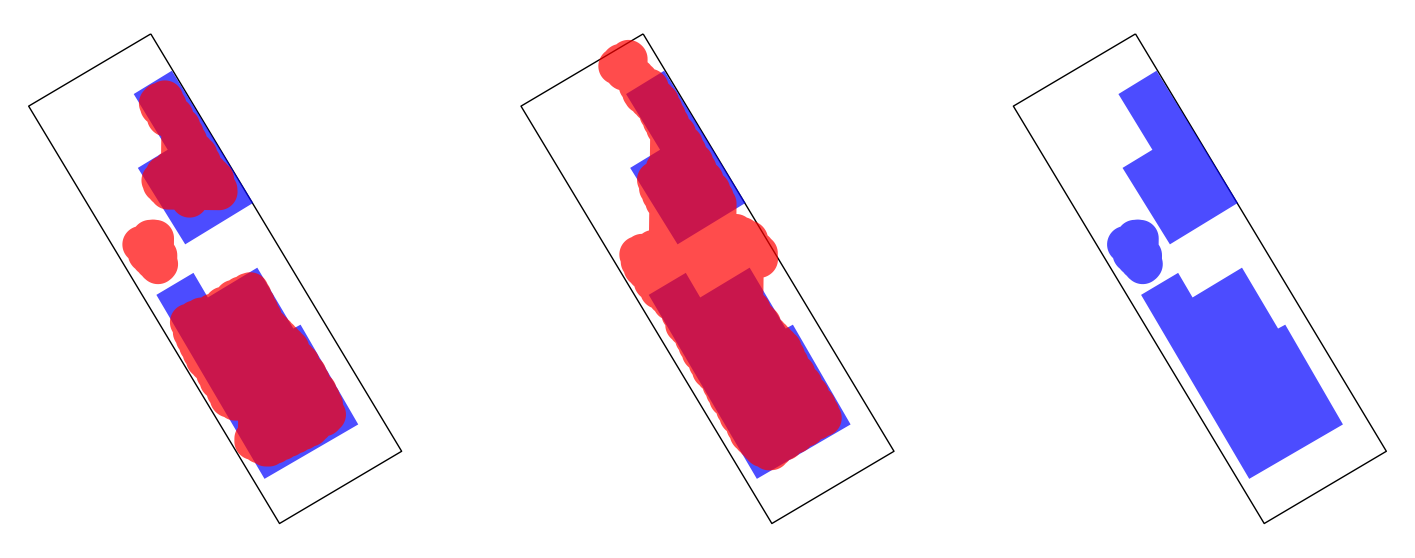

In [142]:
# Case: Yes OSM, yes inferences
_ = run_osm_apn(parcel_apn='48114037')

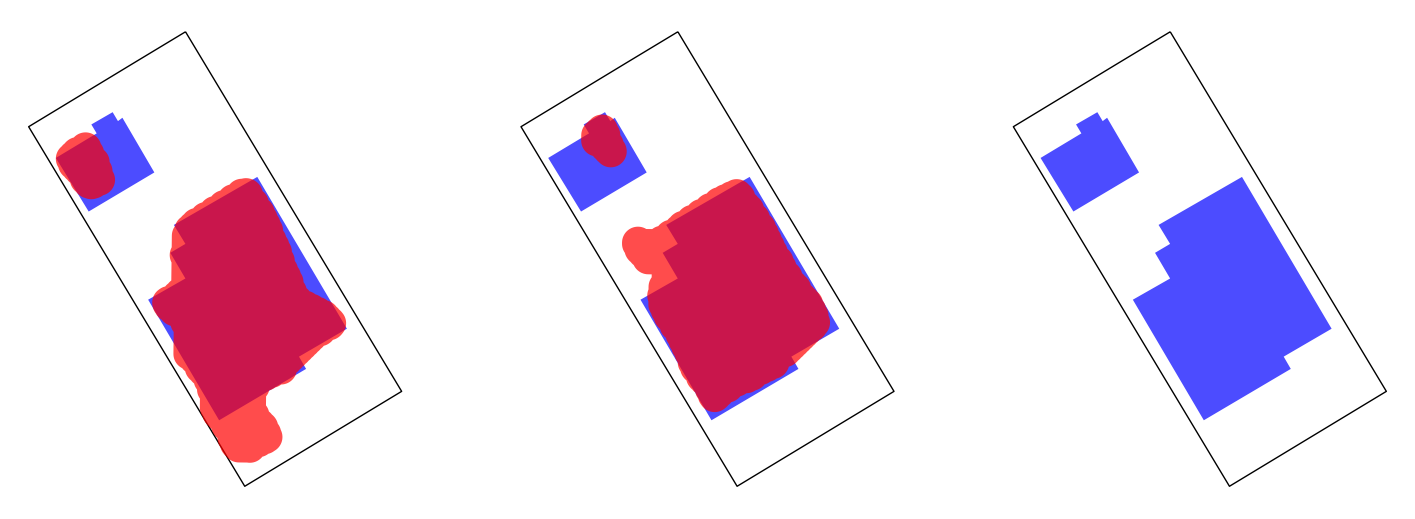

In [141]:
parcel_build = run_osm_apn(parcel_apn='48114039')

In [131]:
# Note main building is correctly flagged for an expansion
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,True,False,True,"POLYGON ((-121.85888 37.34933, -121.85884 37.3..."
1,False,True,False,False,"POLYGON ((-121.85899 37.34946, -121.85894 37.3..."


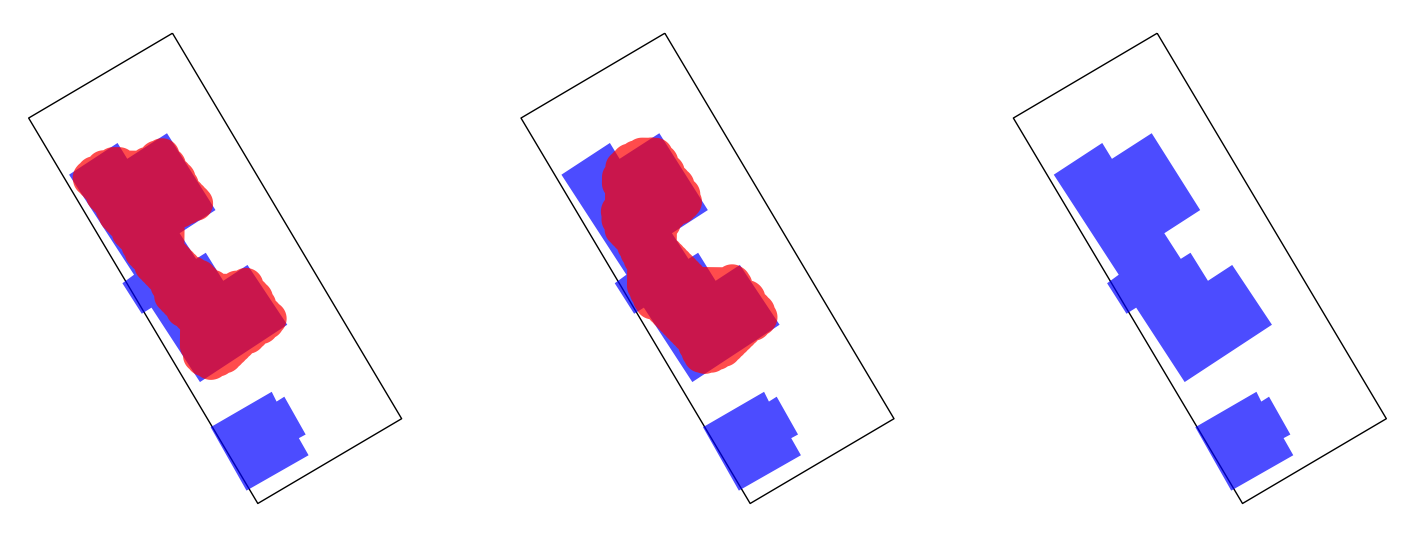

In [132]:
_ = run_osm_apn(parcel_apn='48114071')

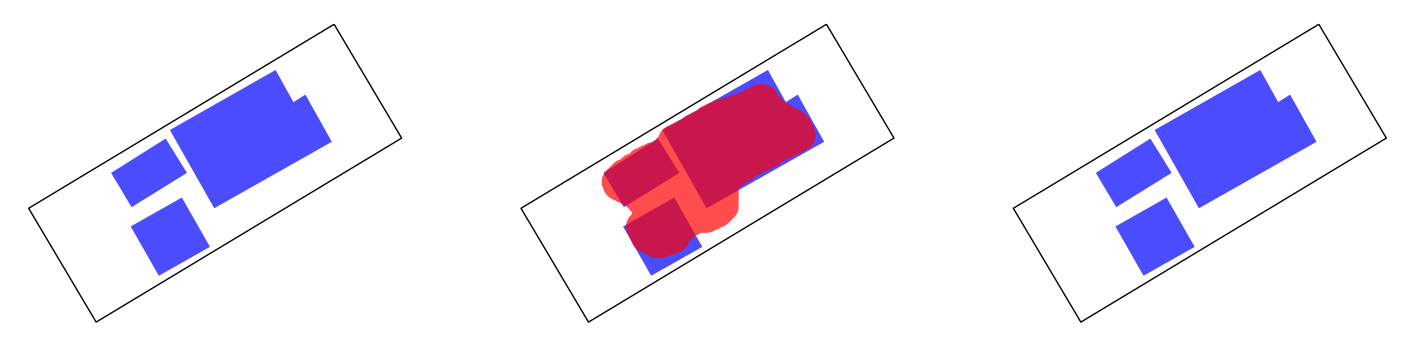

In [133]:
# Case: No inferences, yes OSM
parcel_build = run_osm_apn(parcel_apn='48147016')

In [57]:
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
2,False,True,False,False,"POLYGON ((-121.85541 37.34772, -121.85528 37.3..."
0,True,True,False,False,"POLYGON ((-121.85540 37.34766, -121.85536 37.3..."
1,False,True,False,False,"POLYGON ((-121.85548 37.34768, -121.85541 37.3..."


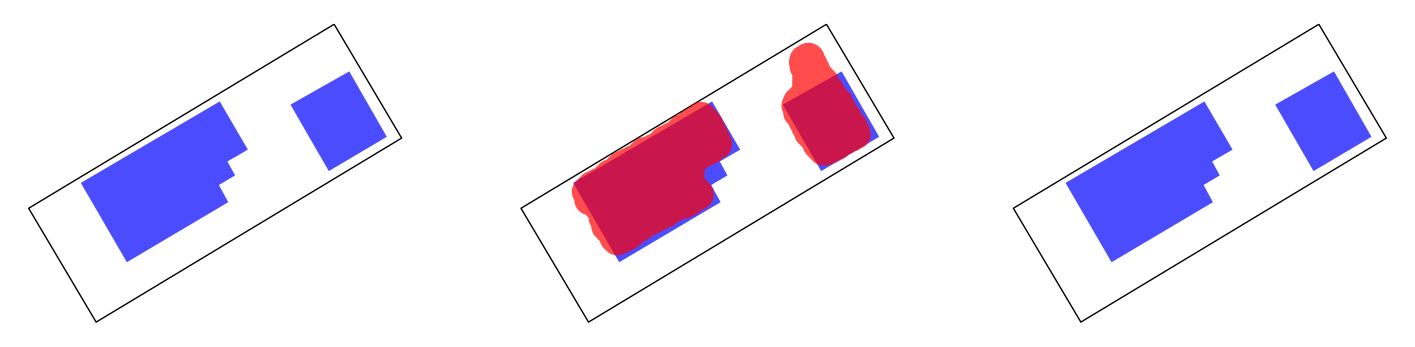

In [134]:
#    
_ = run_osm_apn(parcel_apn='48147006')

# Note: we should ideally check protrusions for small buildings as well?
# In this case we actually have two small buildings, one not captured by OSM
# See google maps: 37.34749, -121.85587 

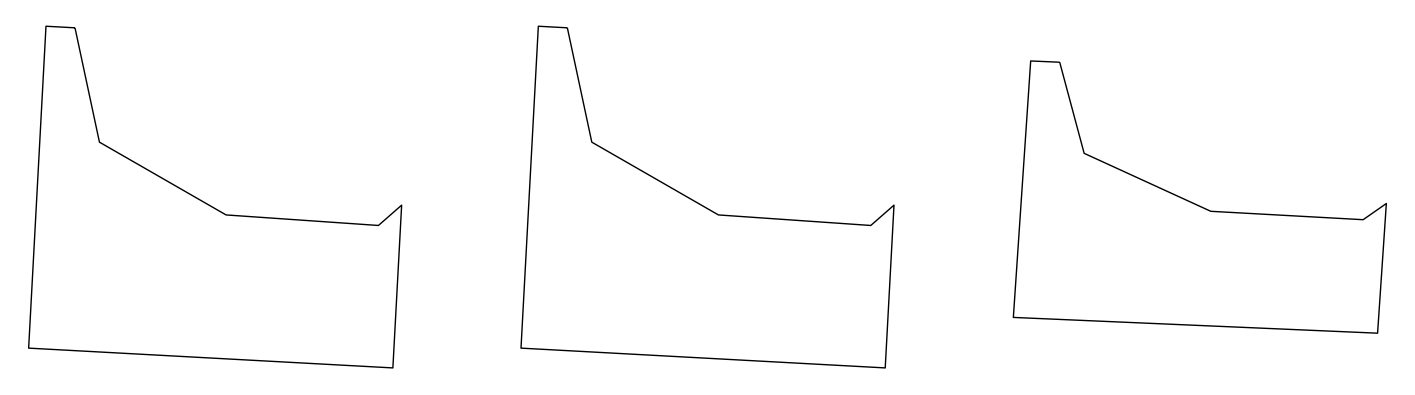

In [135]:
# Case: No OSM, no inferences  
_ = run_osm_apn(parcel_apn='74209051')

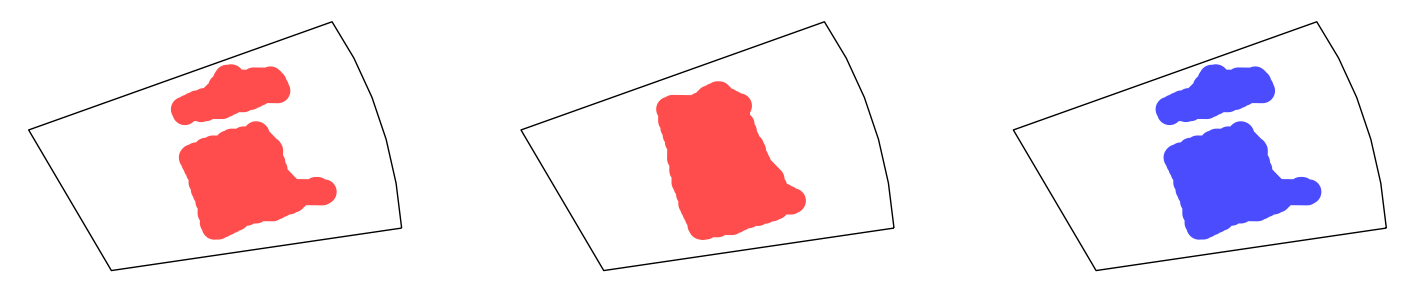

In [136]:
# Case: No OSM, yes inferences
parcel_build = run_osm_apn(parcel_apn='58708023')

In [62]:
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,False,None,False,"POLYGON ((-121.84690 37.40775, -121.84690 37.4..."
1,False,False,False,False,"POLYGON ((-121.84691 37.40780, -121.84691 37.4..."


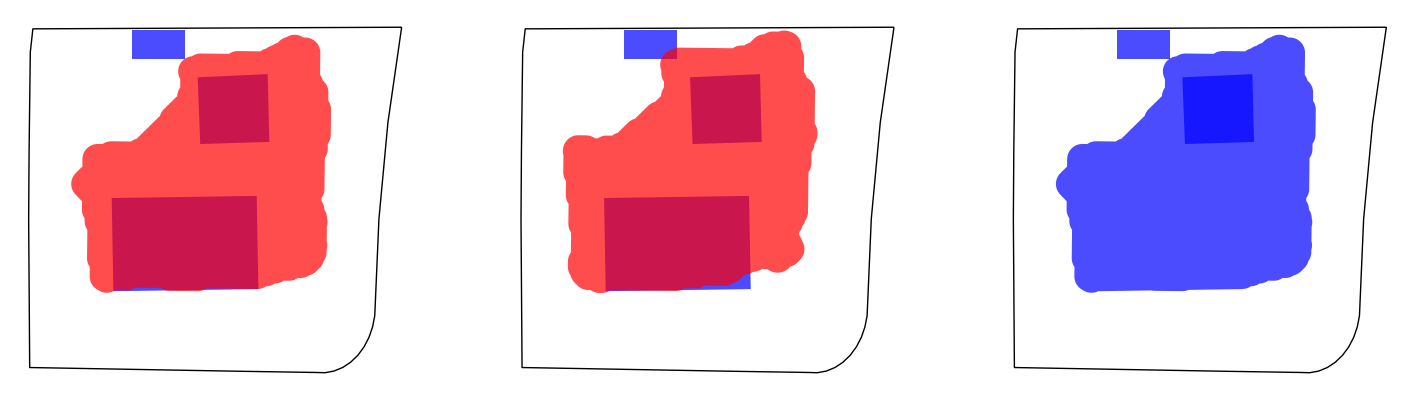

In [137]:
parcel_build = run_osm_apn(parcel_apn='41934035')

In [87]:
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,False,True,False,"POLYGON ((-121.93053 37.24491, -121.93054 37.2..."
1,False,True,False,False,"POLYGON ((-121.93039 37.24502, -121.93031 37.2..."
2,False,True,False,False,"POLYGON ((-121.93047 37.24504, -121.93047 37.2..."


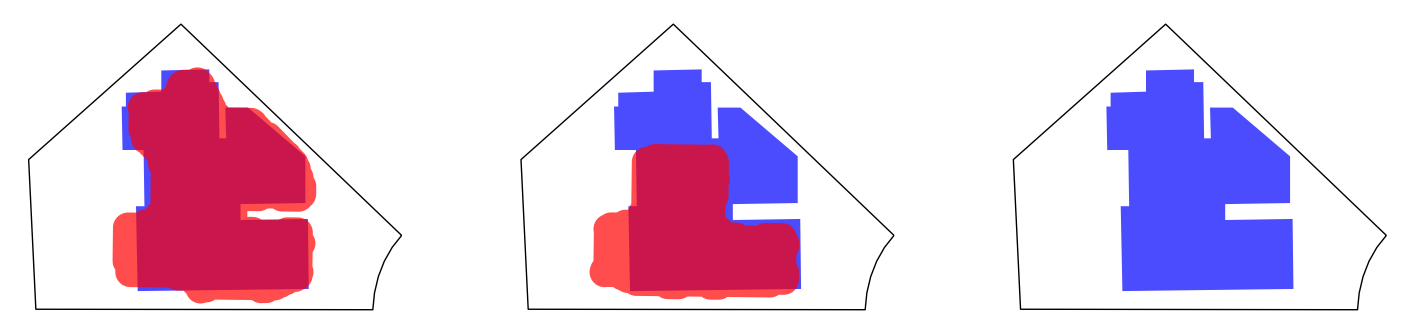

In [138]:
parcel_build = run_osm_apn(parcel_apn='58630050')

In [92]:
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,True,False,True,"POLYGON ((-121.86648 37.40674, -121.86649 37.4..."


In [99]:
apns = ['26114059', '23044043', '23018080', '26105030', 
        #'27461031',
        '27461054', '27410003', '27415071', '27415152', '47230014']

26114059


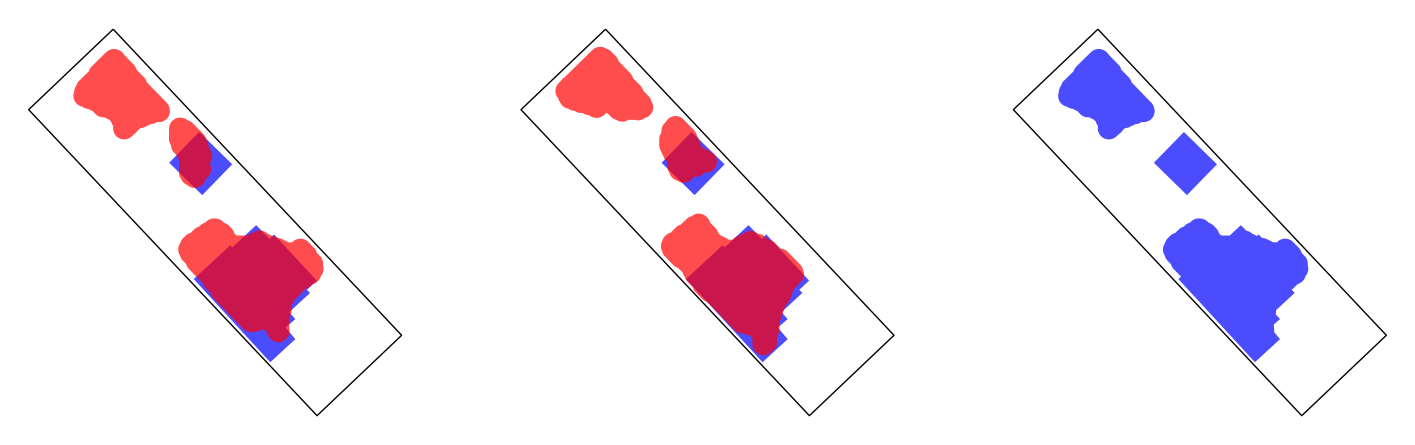

  main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0               True    False               True               False   
1              False     True              False               False   
2              False    False              False               False   

                                            geometry  
0  POLYGON ((-121.92334 37.33739, -121.92334 37.3...  
1  POLYGON ((-121.92336 37.33751, -121.92331 37.3...  
2  POLYGON ((-121.92351 37.33761, -121.92351 37.3...  


23044043


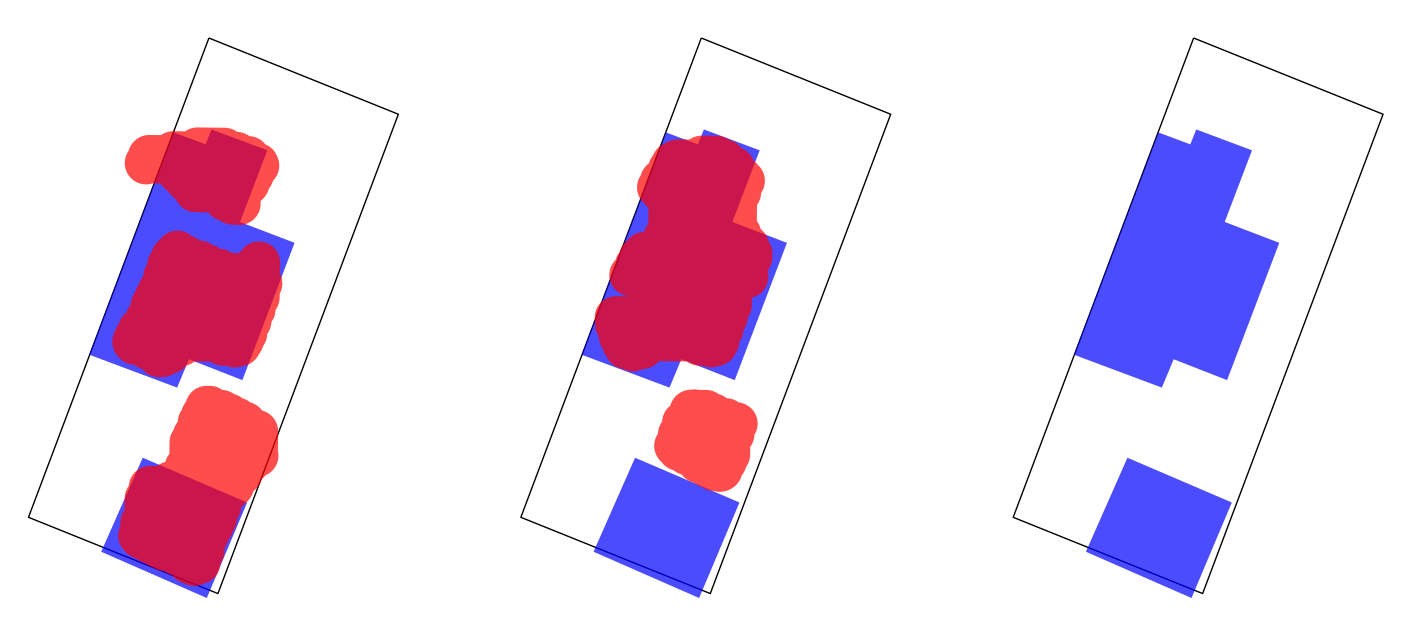

  main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0               True     True              False               False   
0              False     True              False               False   

                                            geometry  
0  POLYGON ((-121.92701 37.34084, -121.92694 37.3...  
0  POLYGON ((-121.92700 37.34071, -121.92697 37.3...  


23018080


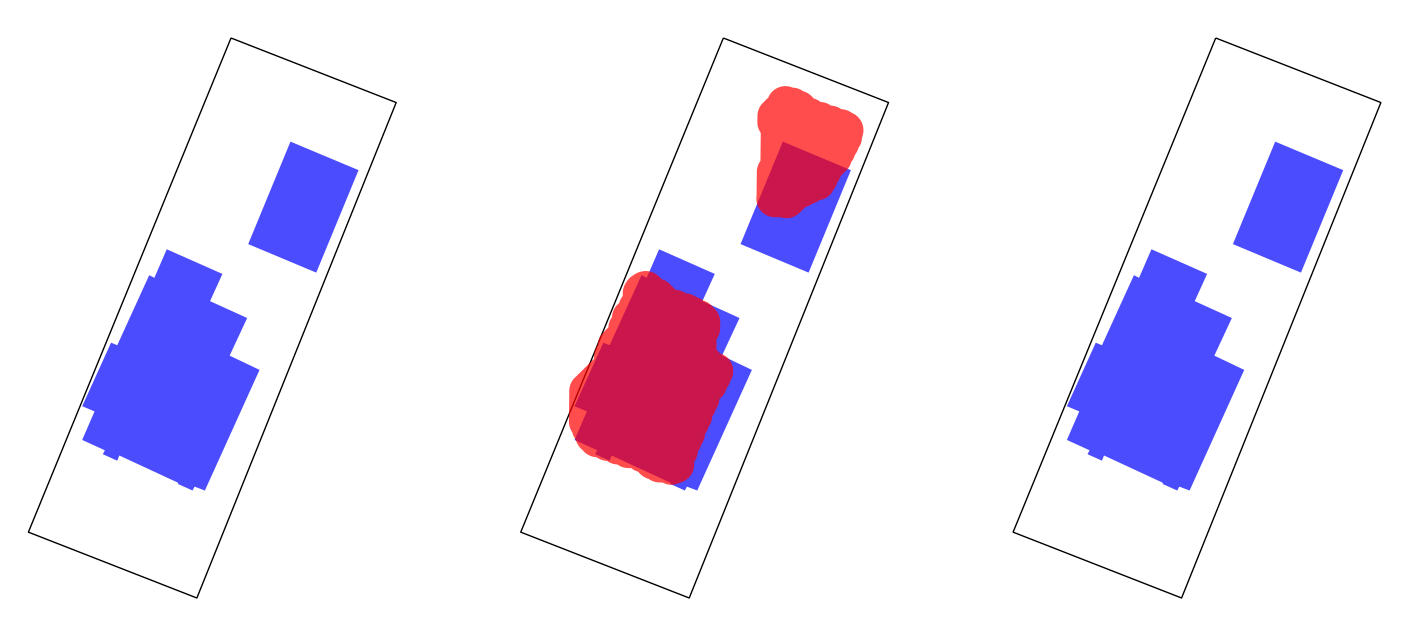

   main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                False   
1               False      True               False                False   

                                            geometry  
0  POLYGON ((-121.93157 37.34285, -121.93157 37.3...  
1  POLYGON ((-121.93151 37.34303, -121.93147 37.3...  


26105030


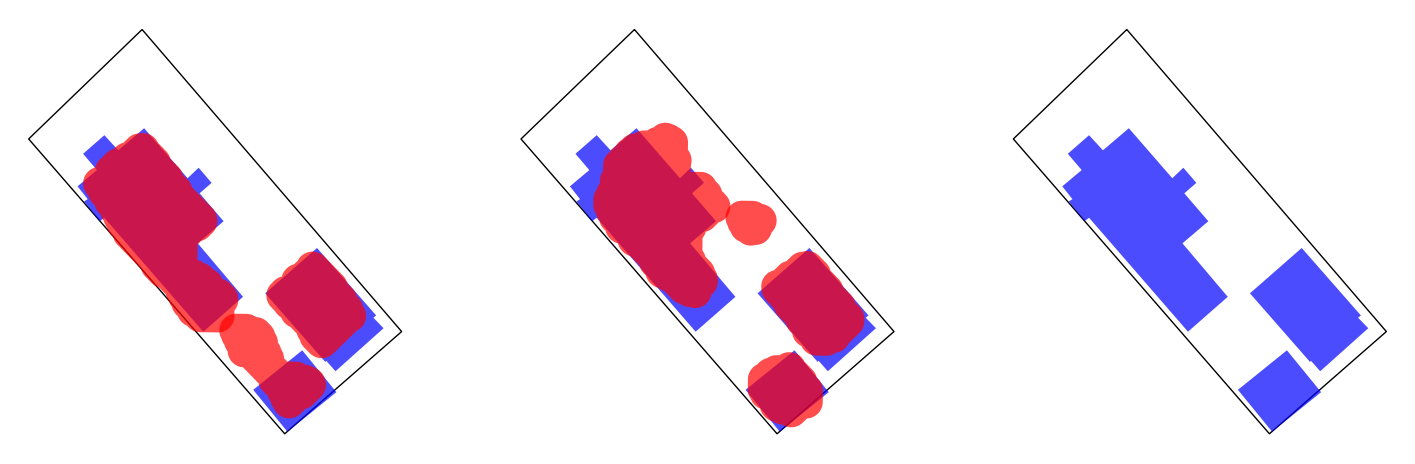

  main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0               True     True              False               False   
1              False     True              False               False   
0              False     True              False               False   

                                            geometry  
0  POLYGON ((-121.91150 37.33768, -121.91151 37.3...  
1  POLYGON ((-121.91126 37.33756, -121.91126 37.3...  
0  POLYGON ((-121.91134 37.33753, -121.91129 37.3...  


27461054


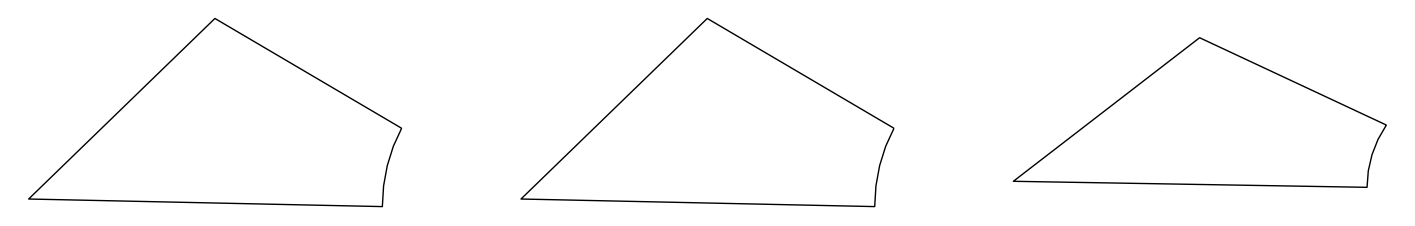

Empty GeoDataFrame
Columns: [main_building_flag, OSM_flag, expansion_OSM_flag, expansion_2016_flag, geometry]
Index: []


27410003


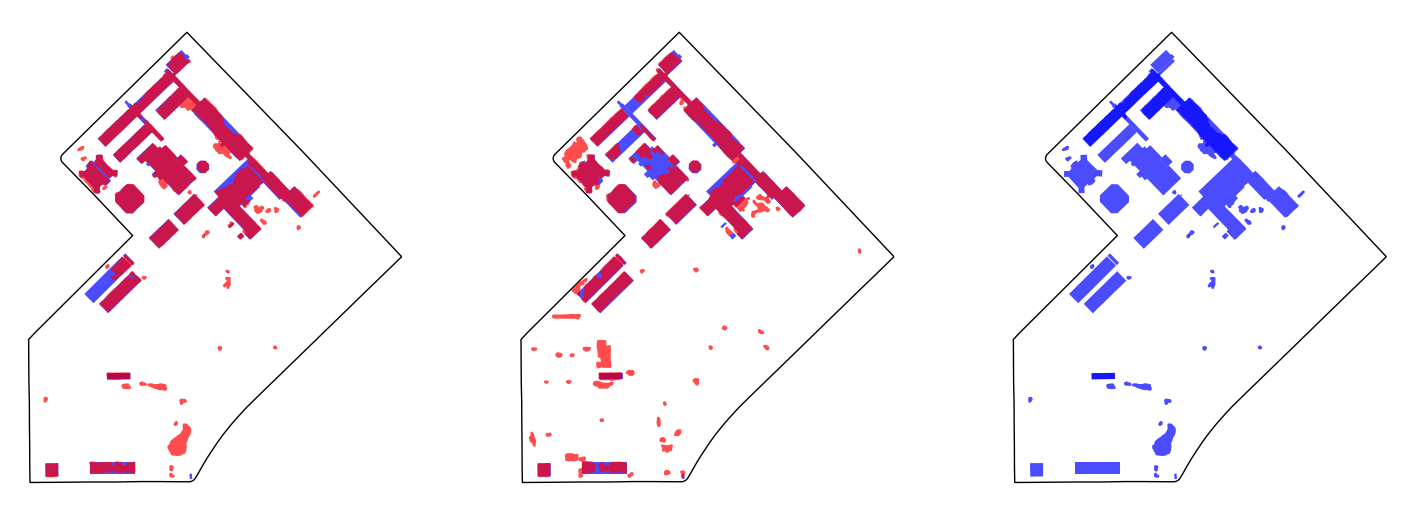

   main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0                True    False               True                True   
14              False     True              False               False   
18              False     True              False               False   
25              False     True              False               False   
5               False     True              False               False   
4               False     True              False               False   
12              False     True              False               False   
1               False     True              False               False   
22              False     True              False               False   
19              False     True              False               False   
17              False     True              False               False   
21              False     True              False               False   
11              False     True              False  

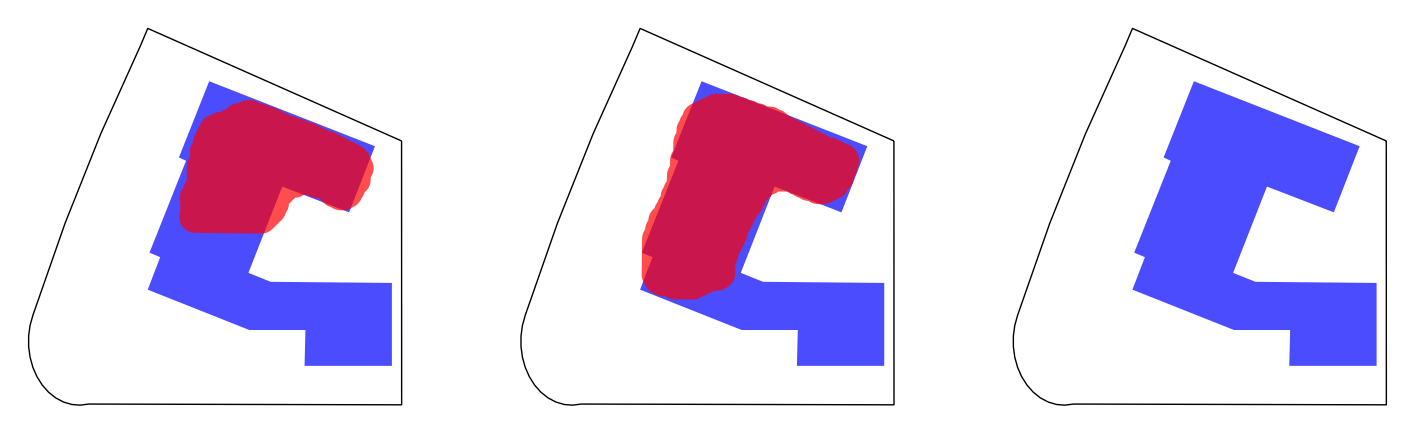

  main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0               True     True              False               False   

                                            geometry  
0  POLYGON ((-121.92345 37.32462, -121.92344 37.3...  


27415152


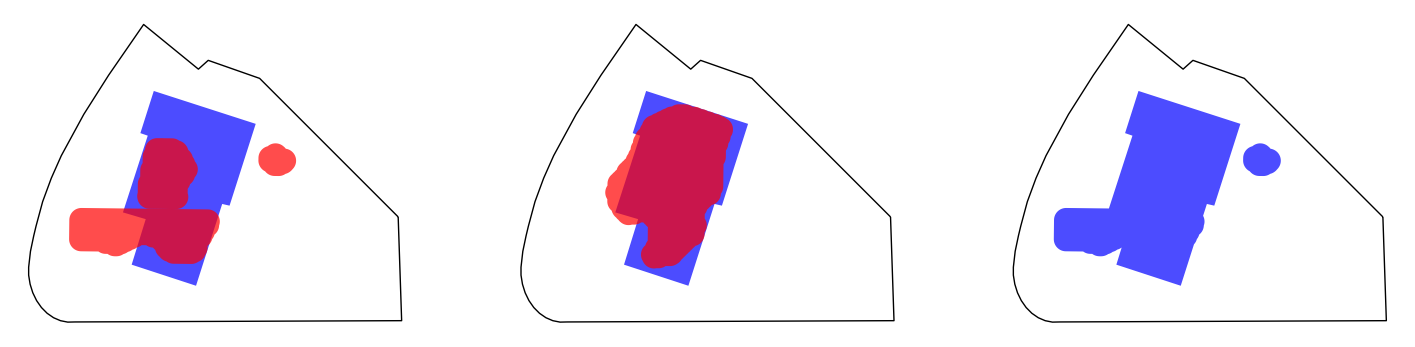

  main_building_flag OSM_flag expansion_OSM_flag expansion_2016_flag  \
0               True    False               True                True   
3              False    False              False               False   

                                            geometry  
0  POLYGON ((-121.92215 37.32461, -121.92215 37.3...  
3  POLYGON ((-121.92187 37.32470, -121.92187 37.3...  


47230014


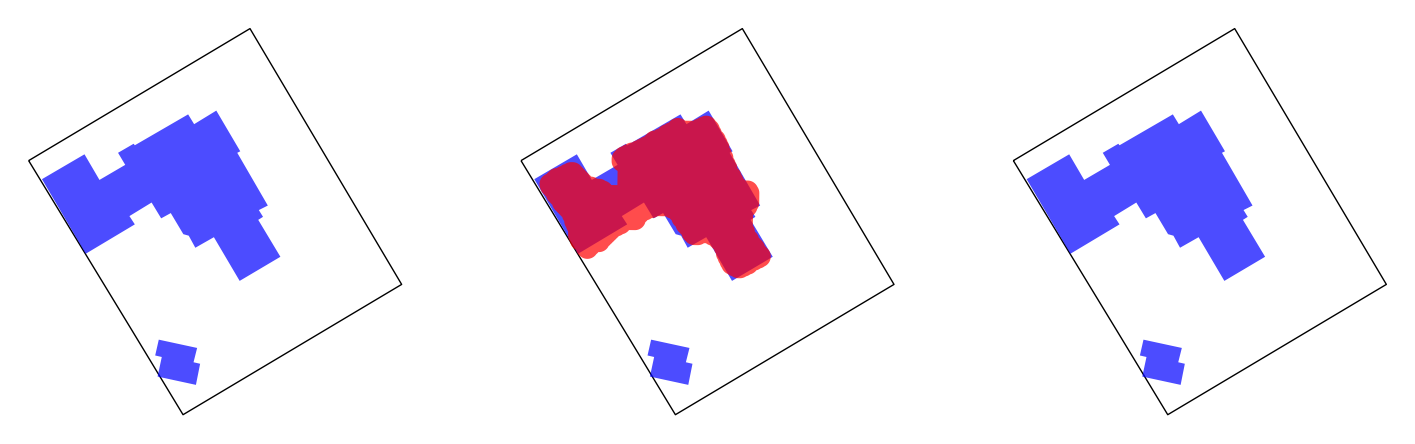

   main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
2               False      True               False                False   
1               False      True               False                False   

                                            geometry  
2  POLYGON ((-121.87051 37.33306, -121.87055 37.3...  
1  POLYGON ((-121.87061 37.33287, -121.87060 37.3...  




In [139]:
for parcel_apn in apns:
    print(parcel_apn)
    parcel_build = run_osm_apn(parcel_apn=parcel_apn)
    print(parcel_build)
    print('\n')

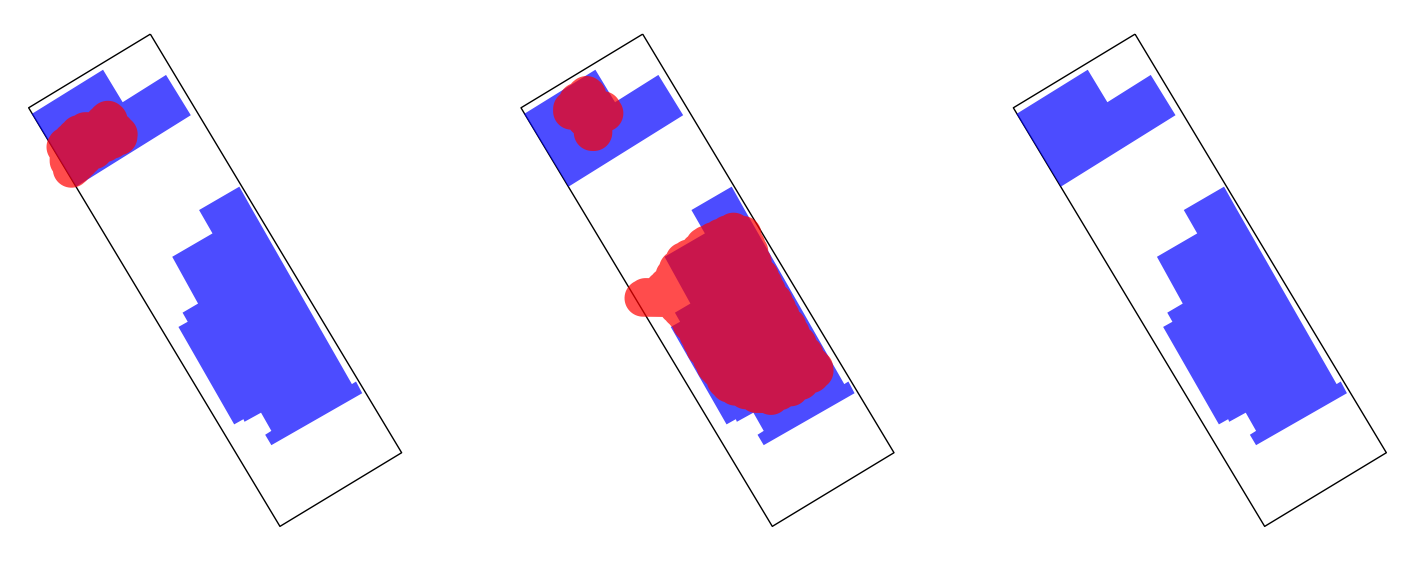

In [140]:
parcel_build = run_osm_apn('48115069')

In [128]:
parcel_build

,main_building_flag,OSM_flag,expansion_OSM_flag,expansion_2016_flag,geometry
0,True,True,False,False,"POLYGON ((-121.85586 37.35169, -121.85585 37.3..."
2,False,True,False,False,"POLYGON ((-121.85617 37.35190, -121.85610 37.3..."


In [112]:
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data('48115069', sj_parcels_res, sj_parcel_permit)
    

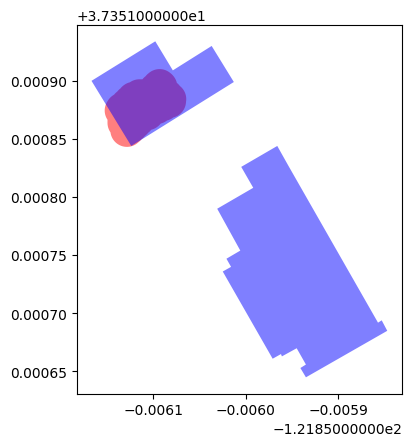

In [121]:
fig, ax = plt.subplots()
inferred_buildings_2020_parcel.plot(ax=ax, color='red', alpha=0.5)
osm_buildings_parcel.plot(ax=ax, color='blue', alpha=0.5)
plt.show()

In [117]:
osm_buildings_parcel

,index_left,GEOID,index,area,small,large,geometry,iou
0,3193.0,060855036021,786410155,181.446222,0,1,"POLYGON ((-121.85586 37.35169, -121.85585 37.3...",1.000000
2,3193.0,060855036021,786410150,69.934630,1,0,"POLYGON ((-121.85617 37.35190, -121.85610 37.3...",0.998538


In [118]:
# i. Identify main building(s) in OSM and inferences
osm_buildings_parcel.drop('index_left', axis=1, inplace=True)
osm_main_build = osm_buildings_parcel.sort_values('area', ascending=False).iloc[[0]]
osm_main_build_geom = osm_main_build['geometry'].iloc[0]

inference_main_build = inferred_buildings_2020_parcel.sjoin(
    osm_main_build, how='left', predicate='intersects')
inference_main_build = inference_main_build.loc[~inference_main_build['index_right'].isna()]
inference_main_build_geom = inference_main_build.geometry.unary_union
inference_main_build.drop('index_right', axis=1, inplace=True)



In [120]:
osm_main_build

,GEOID,index,area,small,large,geometry,iou
0,060855036021,786410155,181.446222,0,1,"POLYGON ((-121.85586 37.35169, -121.85585 37.3...",1.0


In [123]:
len(inference_main_build)

0

In [119]:
# * Check for building expansion
# ** From OSM
union_main_build = inference_main_build_geom.union(osm_main_build_geom)
diff_main_build = compute_largest_protruding_poly(union_main_build, osm_main_build_geom)




AttributeError: 'NoneType' object has no attribute 'union'

## Compute IoU histogram for all parcels

In [20]:
inferred_buildings_2020_parcel.head()

,GEOID,area,small,large,geometry,iou
0,060855036021,148.727291,0,1,"POLYGON ((-121.85852 37.34948, -121.85852 37.3...",1.0
1,060855036021,19.658631,1,0,"POLYGON ((-121.85857 37.34954, -121.85857 37.3...",1.0
2,060855036021,61.113540,1,0,"POLYGON ((-121.85855 37.34965, -121.85855 37.3...",1.0


In [104]:
def parcel_level_data_check(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # clip inferred buildings and osm buildings
    # i don't think clip is a good idea since it truncates the inferences according to the mask
    # inferred_buildings_2020_parcel = gpd.clip(building_inference_2020, parcel_bounds)

    # def mask_buildings(df, parcel_bounds):
    #   df_out = df.sjoin(parcel_bounds[['geometry','geom']])
    #   # print(df_out)
    #   df_out['iou'] = df_out['geometry'].intersection(df_out['geom']).area/df_out['geom'].area
    #   df_out = df_out[df_out['iou'] > 0.7]
    #   return df_out

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.1]
        if df_out.empty:
            return None
        else:
            return df_out

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

In [108]:
parcel_apns = sj_parcels_res['APN'].unique()

np.random.seed(42)
sample_parcel_apns = np.random.choice(parcel_apns, size=1000, replace=False)
ious = pd.DataFrame()
for parcel_apn in tqdm(sample_parcel_apns):
    inferred_buildings_2020_parcel, _, _, _ = parcel_level_data_check(parcel_apn, sj_parcels_res, sj_parcel_permit)
    if inferred_buildings_2020_parcel is not None:
        inferred_buildings_2020_parcel['parcel_apn'] = parcel_apn
        ious = pd.concat([ious, inferred_buildings_2020_parcel[['iou', 'parcel_apn']]])
        

100%|██████████| 1000/1000 [20:20<00:00,  1.22s/it]


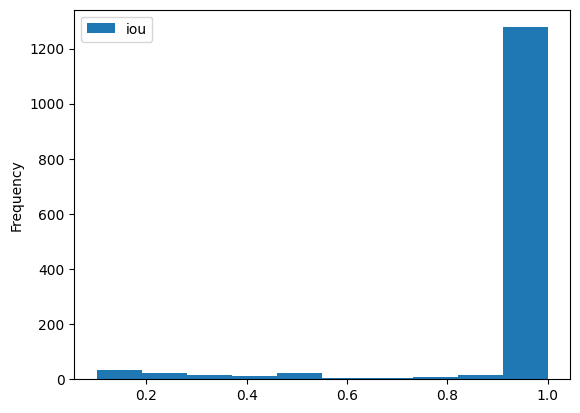

In [110]:
ious.plot.hist()
plt.show()

In [111]:
ious.sort_values('iou').head()

,iou,parcel_apn
0,0.101726,48152052
0,0.102216,27718063
0,0.102381,47743106
0,0.108706,67668003
1,0.111567,43920080
